# How do ion channels shape the action potential?


In this notebook, we will see how sodium (Na⁺) and potassium (K⁺) channels work together to create an action potential. An **action potential** is a brief, rapid rise and fall in a neuron's membrane voltage.  
It's how neurons send signals — like an electrical pulse traveling down the cell.

We will simulate two cases:

1. **Normal neuron (with Na⁺ and K⁺ channels)** → We see an action potential and the Na⁺ and K⁺ currents that make it happen.
2. **Neuron with Na⁺ channels blocked (using TTX)** → No action potential is produced.

This helps us understand how action potentials depend on the timing and interaction of different ion channels.

In [ ]:
from entitysdk import Client
from obi_auth import get_token
from pathlib import Path

from entitysdk.downloaders.memodel import download_memodel
from entitysdk.models import MEModel
from bluecellulab.simulation import Simulation

# connect to the data platform
token = get_token(environment="production", auth_mode="daf")
client = Client(environment="production", token_manager=token)

### Choose the Neuron Model

We choose a model of a **layer 5 thick-tufted pyramidal cell (L5TPC)** from the **somatosensory cortex of a juvenile (P14) rat**. This type of neuron plays a key role in processing sensory input and sending output to other brain regions.

**Note**: Only models from the **somatosensory cortex (SSCX)** support TTX blocking at the moment

In [2]:
entity_ID = "4846377e-b403-4fa8-bfd3-9b95506f9dc3"

### Download the MEModel

We download the neuron model (**MEModel**), which represents a real biological cell by combining its morphology (shape) and electrical behavior (ion channels, firing properties).  
This gives us everything we need to simulate that neuron in silico.

In [3]:
memodel = client.get_entity(
    entity_type=MEModel,
    entity_id=entity_ID,
)
memodel_path=Path(str(memodel.id))
downloaded_memodel = download_memodel(
    client, memodel=memodel, output_dir=memodel_path
)

We get the files that describe the neuron’s shape and behavior.

In [4]:
hoc_folder = memodel_path / "hoc"
morph_folder = memodel_path / "morphology"
mechanisms_folder = memodel_path / "mechanisms"

morph_file = next(morph_folder.glob("*.asc"))
hoc_file = next(hoc_folder.glob("*.hoc"))

### Compile ion channel mechanisms

This step converts the `.mod` files — which define how ion channels behave — into a format that NEURON can use.  
It includes the TTX blocker we’ll use later to disable Na⁺ channels.

In [ ]:
# Remove any previous compiled folder (specific to Mac M1/M2 architecture)
!rm -r arm64

# Add the TTX mechanism file, which allows us to block Na⁺ channels in the simulation
!cp TTXDynamicsSwitch.mod {memodel_path}/mechanisms

# Compile all the mechanism (.mod) files in the mechanisms folder
!nrnivmodl {memodel_path}/mechanisms

### Load model parameters

We load the holding and threshold currents from the model’s calibration.  
These values define how the cell behaves during stimulation.

In [6]:
from bluecellulab.circuit.circuit_access import EmodelProperties
holding_current = memodel.calibration_result.holding_current
threshold_current = memodel.calibration_result.threshold_current
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

print(f"threshold current is {emodel_properties.threshold_current} nA.")
print(f"holding current is {emodel_properties.holding_current} nA.")

threshold current is 0.47796937783552224 nA.
holding current is -0.14687500000000003 nA.


We set the temperature and initial membrane voltage. These values are already chosen to match the model’s physiology.

In [7]:
from bluecellulab.simulation.neuron_globals import NeuronGlobals
neuron_globals = NeuronGlobals.get_instance()
neuron_globals.temperature = 34.0
neuron_globals.v_init = -73.0

### Create the simulated neuron

We now build the neuron inside the simulator using the downloaded files and parameters.

In [8]:
from bluecellulab.cell.core import Cell
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

### Check available variables
We check which ionic currents and other variables can be recorded from the soma.

In [9]:
from bluecellulab.cell.section_tools import currents_vars

mech_vars = currents_vars(cell.soma)
mech_vars

{'i_pas': {'units': 'mA/cm²', 'kind': 'nonspecific_current'},
 'ica': {'units': 'mA/cm²', 'kind': 'ionic_current'},
 'ihcn_Ih': {'units': 'mA/cm²', 'kind': 'nonspecific_current'},
 'ik': {'units': 'mA/cm²', 'kind': 'ionic_current'},
 'ina': {'units': 'mA/cm²', 'kind': 'ionic_current'}}

In [10]:
currents_vars(cell.cell.axon[0])


{'i_pas': {'units': 'mA/cm²', 'kind': 'nonspecific_current'},
 'ica': {'units': 'mA/cm²', 'kind': 'ionic_current'},
 'ik': {'units': 'mA/cm²', 'kind': 'ionic_current'},
 'ina': {'units': 'mA/cm²', 'kind': 'ionic_current'}}

The result shows all the variables we can record from the soma.

Each entry represents a current:
- `'ina'` → sodium current  
- `'ik'` → potassium current  
- `'ica'` → calcium current  
- `'ihcn_Ih'` and `'i_pas'` → other non-specific background currents

Here, we record the total Na⁺ (ina) and K⁺ (ik) currents from the soma

In [11]:
cell.add_variable_recording("ina", cell.soma, 0.5)  # total sodium current
cell.add_variable_recording("ik", cell.soma, 0.5)   # total potassium current
cell.add_variable_recording("v", cell.soma, 0.5)    # membrane potential

### Inject current into the neuron

We inject a step current into the center of the soma, starting at 100 ms and lasting for 1350 ms.  
This is like giving the neuron a small push to see if it fires.


In [12]:
stim_delay = 100  # ms
stim_dur = 1350  # ms
cell.add_step(stim_delay, stim_dur, 0.5, cell.soma, 0.5)

TStim[0]

### Run the simulation

We simulate the neuron's activity over 2000 ms and record its response.

In [13]:
sim = Simulation()
sim.add_cell(cell)
sim.run(2000, dt=0.05, cvode=False)

### Load simulation results

We extract the time points, membrane voltage, and the Na⁺ and K⁺ current densities recorded during the simulation.

In [14]:
t = cell.get_time()
v_trace = cell.get_variable_recording("v", cell.soma, 0.5)
ina_density = cell.get_variable_recording("ina", cell.soma, 0.5)     # Na⁺ current (mA/cm²)
ik_density = cell.get_variable_recording("ik", cell.soma, 0.5)       # K⁺ current (mA/cm²)

### Plot full simulation

We plot the membrane voltage and the Na⁺ / K⁺ current densities across the entire simulation.

In [15]:
import matplotlib.pyplot as plt
def plot_voltage_and_currents(t, v, ina, ik):
    plt.figure(figsize=(8, 6))

    plt.subplot(3, 1, 1)
    plt.plot(t, v, color="black")
    plt.ylabel("V (mV)")
    plt.title("Action potential with Na⁺ / K⁺ current densities")

    plt.subplot(3, 1, 2)
    plt.plot(t, ina, color="blue")
    plt.ylabel("iNa (mA/cm²)")

    plt.subplot(3, 1, 3)
    plt.plot(t, ik, color="red", alpha=0.6)
    plt.ylabel("iK (mA/cm²)")
    plt.xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

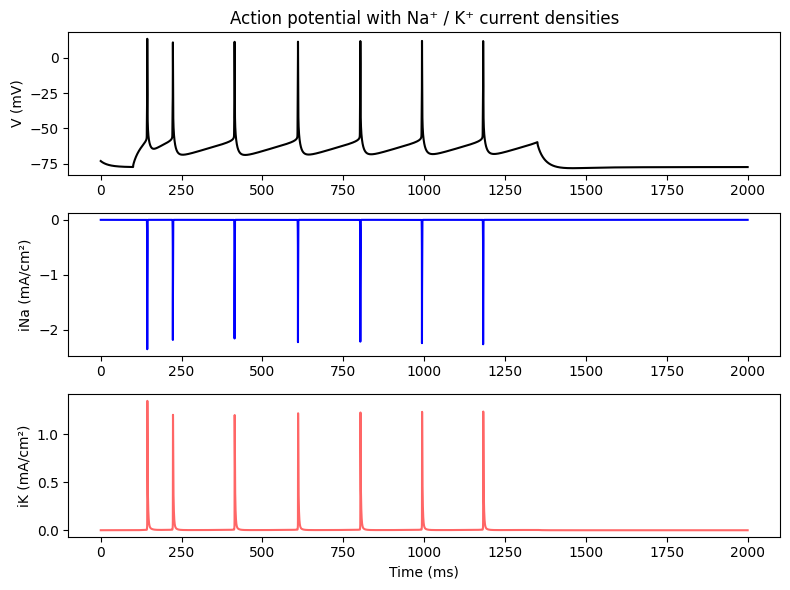

In [16]:
plot_voltage_and_currents(t, v_trace, ina_density, ik_density)

### Zoom in on one action potential

We focus on a small time window to see the detailed timing of the Na⁺ and K⁺ currents during a single spike.

In [17]:
def plot_zoomed_ap(t, v, ina, ik, t_start=140, t_end=150):
    mask = (t >= t_start) & (t <= t_end)
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Membrane voltage (left axis)
    ax1.plot(t[mask], v[mask], color="black", label="Voltage (Vm)")
    ax1.set_ylabel("Vm (mV)")
    ax1.set_xlabel("Time (ms)")

    # Ionic currents (right axis)
    ax2 = ax1.twinx()
    ax2.plot(t[mask], ina[mask], color="blue", label="iNa (mA/cm²)")
    ax2.plot(t[mask], ik[mask], color="red", alpha=0.6, label="iK (mA/cm²)")
    ax2.set_ylabel("Current density (mA/cm²)")

    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.title("AP with Na⁺ and K⁺ current densities (zoomed)")
    plt.tight_layout()
    plt.show()

To zoom in on a specific time window, just set t_start and t_end. For example:

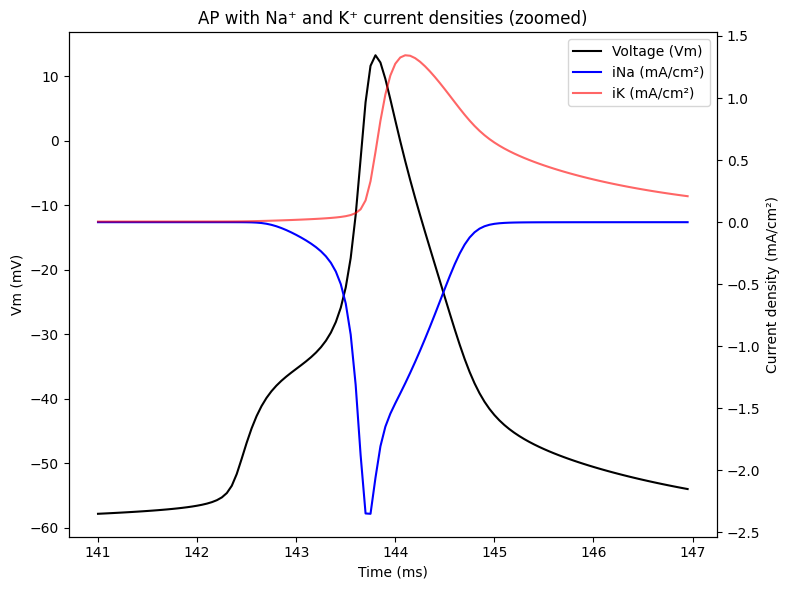

In [18]:
plot_zoomed_ap(t, v_trace, ina_density, ik_density, t_start=141, t_end=147)

The plot shows a zoomed-in view of one action potential. The brief inward Na⁺ current (blue, seen as a small negative deflection) occurs first and initiates the sharp rise in membrane potential (black).  
A delayed outward K⁺ current (red, positive deflection) follows, helping to repolarize the cell after the spike.

### Apply TTX to block Na⁺ channels

We simulate the effect of **TTX (tetrodotoxin)**, a powerful neurotoxin that blocks voltage-gated sodium (Na⁺) channels. Since Na⁺ influx is essential for triggering an action potential, blocking these channels prevents the neuron from spiking — even if we inject current.

In [19]:
try:
    cell.enable_ttx()
except AttributeError:
    print("This model does not support TTX blocking. Please use a model from the somatosensory cortex (SSCX).")

### Run the simulation with Na⁺ channels blocked

We run the same simulation again, but this time with TTX applied.  
Without Na⁺ channels, the neuron cannot depolarize enough to fire — so no spike should appear.

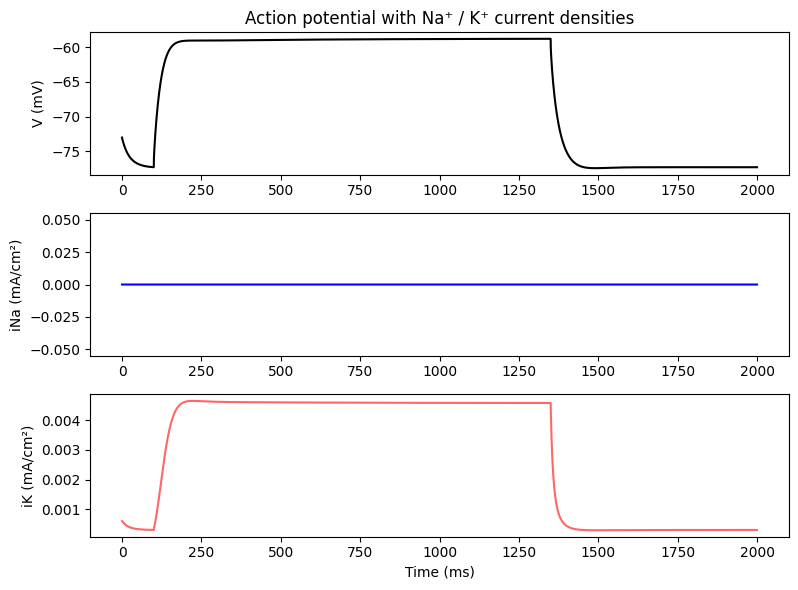

In [20]:
sim.run(2000, dt=0.05, cvode=False)

t = cell.get_time()
v_trace = cell.get_variable_recording("v", cell.soma, 0.5)
ina_density = cell.get_variable_recording("ina", cell.soma, 0.5)  # mA/cm²
ik_density = cell.get_variable_recording("ik", cell.soma, 0.5)    # mA/cm²

plot_voltage_and_currents(t, v_trace, ina_density, ik_density)

**Questions:**  

Why do neurons need both Na⁺ and K⁺ channels to create an action potential?

What happens if you double the current? What if it's too low?

What does this tell you about the role of K⁺ channels alone?